In [2]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler


In [3]:
file_path = 'new_Hotel_reviews_20k.csv'


In [11]:
# CSV 파일 불러오기
data = pd.read_csv(file_path)
data.drop_duplicates(inplace=True)





,rating_review,review_full
1,1,We have been a frequent visitor at this chain ...
47,1,Vile Anti-Sikh staff. Bletently tell customers...
52,1,"I have just left Cafe Nirvana in disgust, The ..."
73,1,Having heard so much about this legendary outl...
90,1,"They get a 1 not for the food or ambience, but..."
...,...,...
19984,1,The worst of all dhabas I have visited till to...
19990,1,I adore Indian cuisine and am spoiled by my in...
19991,1,A walking distance from the Royal Plaza where ...
19994,1,The grilled meat dish I got was mostly bone an...


In [ ]:
# 리뷰와 레이블 데이터 추출
reviews = data['review_full'][::2]
labels = data['rating_review'][::2]

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# 텍스트 데이터 전처리
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # 단어 토큰화
    words = word_tokenize(text)
    # 불용어 제거 및 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    # 리스트를 공백을 포함한 문자열로 변환
    processed_text = ' '.join(words)
    return processed_text

# 텍스트 정제 및 불용어 제거
reviews = reviews.apply(preprocess_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(reviews)
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# 데이터 정규화
scaler = MinMaxScaler()
padded_sequences = scaler.fit_transform(padded_sequences)


# 텍스트 데이터 전처리
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(reviews)
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

c:\Users\JORON\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


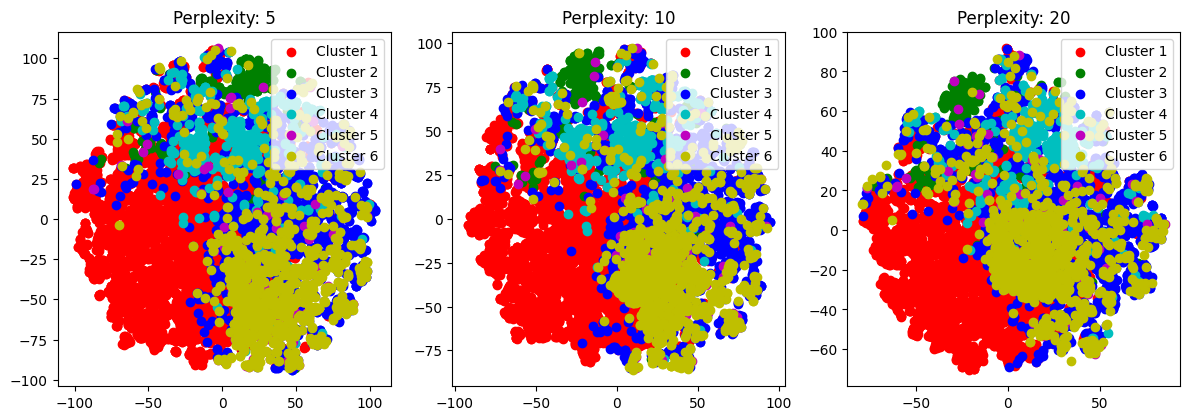

In [4]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# k-means 클러스터링 수행
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(padded_sequences)

# perplexities = [5, 10, 15, 25, 50, 100]
perplexities = [5, 10, 20]

plt.figure(figsize=(12, 8))
for i, perplexity in enumerate(perplexities):
    plt.subplot(2, 3, i + 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_representation = tsne.fit_transform(padded_sequences)

    # 시각화
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    for j in range(num_clusters):
        plt.scatter(tsne_representation[cluster_labels == j, 0], tsne_representation[cluster_labels == j, 1], color=colors[j], label=f'Cluster {j+1}')
    plt.title(f'Perplexity: {perplexity}')
    plt.legend()

plt.tight_layout()
plt.show()

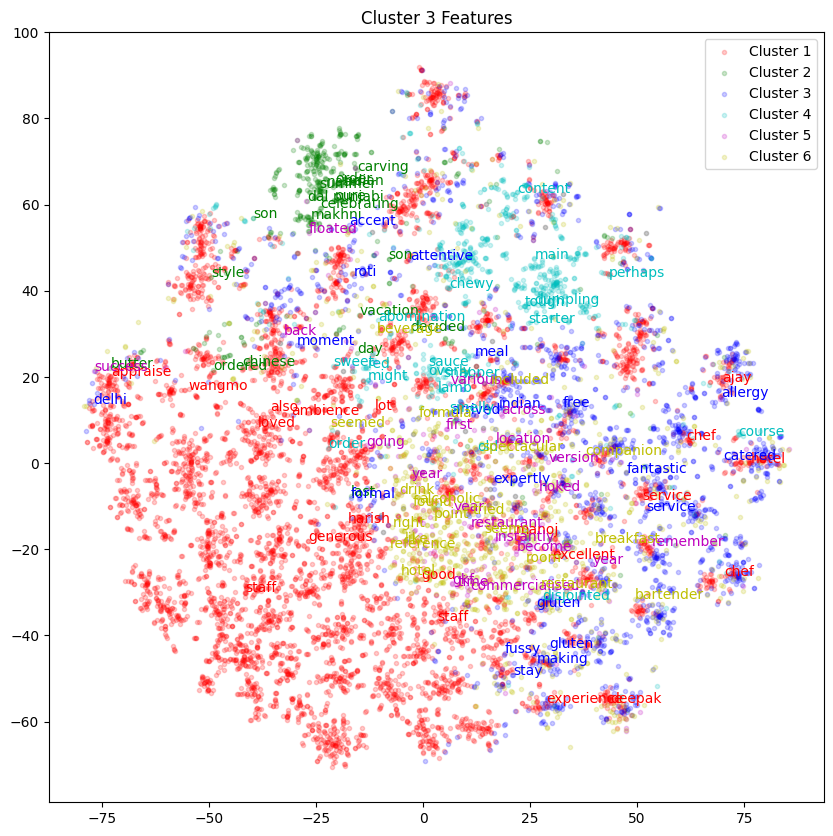

In [5]:
# 선택한 perplexity에 대한 클러스터 특징 확인
selected_perplexity = 20  # 예시로 선택한 perplexity 값
selected_cluster_label = cluster_labels[perplexities.index(selected_perplexity)]

# 선택한 클러스터에 포함된 특징 추출
features = padded_sequences[cluster_labels == selected_cluster_label]

# 특징을 단어로 역추적
reverse_word_index = {index: word for word, index in word_index.items()}
words = [[reverse_word_index.get(index, '') for index in feature] for feature in features]

# 단어를 클러스터 위에 표시
plt.figure(figsize=(10, 10))
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i in range(num_clusters):
    cluster_features = [word for word in words[i] if word != '']
    for j in range(min(20, len(cluster_features))):  # 최대 10개 단어만 표시
        plt.text(tsne_representation[cluster_labels == i, 0][j],
                 tsne_representation[cluster_labels == i, 1][j],
                 cluster_features[j],
                 color=colors[i])
    plt.scatter(tsne_representation[cluster_labels == i, 0],
                tsne_representation[cluster_labels == i, 1],
                marker='.',
                c=colors[i],
                alpha=0.2,
                label=f'Cluster {i+1}')
plt.title(f'Cluster {selected_cluster_label + 1} Features')
plt.legend()
plt.show()

In [19]:
import pandas as pd

# 데이터 프레임 초기화
df_clusters = pd.DataFrame(columns=['Cluster', 'Word'])

# 각 클러스터에 대해 데이터 프레임 열 생성
for i in range(num_clusters):
    cluster_features = [word for word in words[i] if word != '']
    cluster_data = pd.DataFrame({'Cluster': [i+1] * len(cluster_features),
                                 'Word': cluster_features})
    df_clusters = pd.concat([df_clusters, cluster_data], ignore_index=True)

# 데이터 프레임 출력
print(df_clusters)

    Cluster          Word
0         1           lot
1         1      appraise
2         1          chef
3         1        deepak
4         1          chef
..      ...           ...
211       6          bill
212       6  astronomical
213       6         money
214       6          blow
215       6            go

[216 rows x 2 columns]


In [38]:
import pandas as pd

# Create a DataFrame with the word lists for each cluster
cluster_word_lists = []
for i in range(num_clusters):
    cluster_words = df_clusters[df_clusters['Cluster'] == i+1]['Word'].tolist()
    cluster_word_lists.append(cluster_words)

df_word_lists = pd.DataFrame({'Cluster': range(num_clusters), 'Words': cluster_word_lists})

# Display the word lists in a table
print(df_word_lists.iloc[0,:])

for i in df_word_lists.iloc[0,:]:
    print(i)

for i in df_word_lists.iloc[1,:]:
    print(i)

for i in df_word_lists.iloc[2,:]:
    print(i)

for i in df_word_lists.iloc[3,:]:
    print(i)

for i in df_word_lists.iloc[4,:]:
    print(i)

for i in df_word_lists.iloc[5,:]:
    print(i)

Cluster                                                    0
Words      [lot, appraise, chef, deepak, chef, wangmo, se...
Name: 0, dtype: object
0
['lot', 'appraise', 'chef', 'deepak', 'chef', 'wangmo', 'service', 'staff', 'ajay', 'harish', 'manoj', 'hotel', 'good', 'excellent', 'ambience', 'also', 'staff', 'generous', 'loved', 'experience', 'would', 'definitely', 'go', 'occasion']
1
['son', 'celebrating', 'last', 'day', 'summer', 'vacation', 'ordered', 'dal', 'makhni', 'butter', 'naan', 'son', 'pure', 'punjabi', 'carving', 'indian', 'style', 'chinese', 'decided', 'order', 'veg', 'choupsey', 'omg', 'biggest', 'mistake', 'life', 'although', 'price', 'wise', 'economical', 'choupsey', 'average', 'dal', 'naan', 'amazing']
2
['fantastic', 'meal', 'indian', 'accent', 'stay', 'delhi', 'moment', 'arrived', 'service', 'attentive', 'formal', 'fussy', 'catered', 'expertly', 'gluten', 'allergy', 'making', 'gluten', 'free', 'roti', 'adapting', 'dish', 'food', 'exceptionally', 'good', 'negative', 'w